<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a2_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 37
# Student 1: Jiong Li | 1533312
# Student 2: Peter Elmers | 1734350
# Student 3: P.T.C.M. Tholhuijsen | 1237447

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [3]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [4]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [5]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [6]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

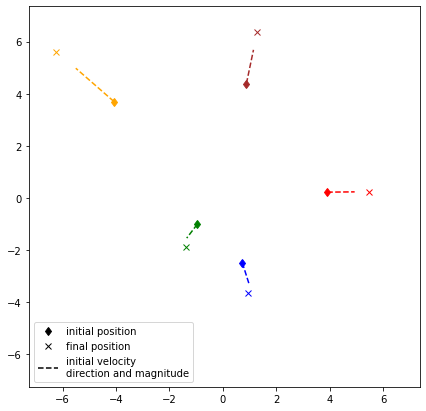

In [7]:
random_idx = np.random.randint(0, 10000)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [8]:
# Pick the best device
import torch

def try_device(device):
    # Try to put an array on given device. If successful, return device. Else, 'cpu'.
    x = torch.ones((1,))
    try:
        x.to(device)
        return device
    except:
        return 'cpu'

device = try_device('cuda')
if device == 'cpu':
    device = try_device('mps')

print(f'Device is set to {device}')

# Move all the little craps into torch things on the device
p_train, v_train, c_train = [torch.Tensor(vec).to(device=device) for vec in [positions_train, velocities_train, charges_train]]
p_valid, v_valid, c_valid = [torch.Tensor(vec).to(device=device) for vec in [positions_valid, velocities_valid, charges_valid]]
p_test, v_test, c_test = [torch.Tensor(vec).to(device=device) for vec in [positions_test, velocities_test, charges_test]]

Device is set to cuda


In [9]:
p_train, v_train, c_train = p_train[:2000], v_train[:2000], c_train[:2000]
p_valid, v_valid, c_valid = p_valid[:400], v_valid[:400], c_valid[:400]

In [10]:
# Create a baseline: particle position = velocity * time + initial
def baseline_predict(p0, v0, time):
    '''
    Return a numpy array of predicted x, y position of each particle in p0.
    Given p0 starting locations, v0 starting velocities, and time to predict.
    Result is computed via linear projection: v0 * time + p0.
    Where p0 and v0 are both (N x 1 x 2 x P) tensors, for N simulations, P particles/sim
    '''
    return p0 + v0 * time


In [11]:
from torch.utils.data import Dataset, DataLoader


class myDataset(Dataset):
    def __init__(self, posi, velo, charge):
        self.posi = posi
        self.velo = velo
        self.charge = charge
    
    def __len__(self):
        return len(self.posi)
    
    def __getitem__(self, index):
        i = list(zip(self.posi, self.velo, self.charge))[index]
        
        p = torch.transpose(i[0][0], 0, 1)
        v = torch.transpose(i[1][0], 0, 1)
        c = i[2]
        
        # x_p, y_p, x_v, y_v, c at t=0
        x = torch.hstack((p, v, c))
        # x.shape = [10, 5, 5]
        
        # (x_p, y_p), (x_p, y_p), (x_p, y_p) at t = 0.5, 1.0, 1.5
        y = torch.hstack((torch.transpose(i[0][1], 0, 1), 
                          torch.transpose(i[0][2], 0, 1), 
                          torch.transpose(i[0][3], 0, 1)))
        # y.shape = [10, 5, 6]
        
        return x, y


In [12]:
tmp = myDataset(p_train, v_train, c_train)
x,y = tmp.__getitem__(0)
y.shape

torch.Size([5, 6])

In [54]:
trainLoader = DataLoader(myDataset(p_train, v_train, c_train), batch_size=10, shuffle=True)
validationLoader = DataLoader(myDataset(p_valid, v_valid, c_valid), batch_size=10, shuffle=True)
testLoader = DataLoader(myDataset(p_test, v_test, c_test), batch_size=10, shuffle=True)

# Model Implementation

In [13]:
import torch.nn as nn
from tqdm import tqdm

Implementation like https://github.com/higgsfield/interaction_network_pytorch/blob/master/Interaction%20Network.ipynb

In [45]:
for i in zip(p_train, v_train, c_train):
    p = torch.transpose(i[0][0], 0, 1)
    v = torch.transpose(i[1][0], 0, 1)
    c = i[2]
   
    data = torch.hstack((p, v, c))
    print(data)
    print(data[:, 0:2])
    print(data[:, 2:4])
    # x_p, y_p, x_v, y_v, c
    break

tensor(-1.9361, device='cuda:0')
tensor([[-1.9361, -0.2276, -0.7878,  0.0267, -1.0000],
        [ 3.6532, -2.7631,  1.5892, -0.4211,  1.0000],
        [-4.5496,  8.2998, -1.2906,  2.3834,  1.0000],
        [-3.0958, -3.0921, -1.9173, -0.5785,  1.0000],
        [ 0.1073, -2.8976,  0.6539, -0.5676, -1.0000]], device='cuda:0')
tensor([[-1.9361, -0.2276],
        [ 3.6532, -2.7631],
        [-4.5496,  8.2998],
        [-3.0958, -3.0921],
        [ 0.1073, -2.8976]], device='cuda:0')
tensor([[-0.7878,  0.0267],
        [ 1.5892, -0.4211],
        [-1.2906,  2.3834],
        [-1.9173, -0.5785],
        [ 0.6539, -0.5676]], device='cuda:0')


In [18]:
len(next(iter(trainLoader)))

2

In [55]:
# object-centric acceleration neural network
class AccelerationModel(nn.Module):
    def __init__(self):
        super(AccelerationModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(5, 25),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(25, 2),
        )
        
    def forward(self, x):
        x = x.view(-1, 5)
        x = self.layers(x)
        return x.view(10, 5, 2)

In [56]:
# object-centric velocity neural network
class VelocityModel(nn.Module):
    def __init__(self):
        super(VelocityModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(4, 16),
            # nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(16, 2),
        )
        
    def forward(self, x):
        x = x.view(-1, 4)
        x = self.layers(x)
        return x.view(10, 5, 2)

In [57]:
# object-centric position neural network
class PositionModel(nn.Module):
    def __init__(self):
        super(PositionModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(16, 2),
        )
        
    def forward(self, x):
        x = x.view(-1, 4)
        x = self.layers(x)
        return x.view(10, 5, 2)

In [58]:
# interaction network
class InteractionNetwork(nn.Module):
    def __init__(self):
        super(InteractionNetwork, self).__init__()
        
        self.acceleration_model = AccelerationModel()
        self.velocity_model = VelocityModel()
        self.position_model = PositionModel()
        
    def forward(self, x, delta_t):
        pred_accelleration = self.acceleration_model(x)
        pred_velocity = self.velocity_model(torch.dstack((x[:, :, 2:4], torch.mul(pred_accelleration, delta_t))))
        pred_position = self.position_model(torch.dstack((x[:, :, 0:2], pred_velocity)))
        return pred_position, pred_velocity
    
interaction_network = InteractionNetwork()
interaction_network.to(device=device)

InteractionNetwork(
  (acceleration_model): AccelerationModel(
    (layers): Sequential(
      (0): Linear(in_features=5, out_features=25, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=25, out_features=2, bias=True)
    )
  )
  (velocity_model): VelocityModel(
    (layers): Sequential(
      (0): Linear(in_features=4, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=2, bias=True)
    )
  )
  (position_model): PositionModel(
    (layers): Sequential(
      (0): Linear(in_features=4, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)

In [59]:
def evaluation(model, test_loader, klass):
    model = model.eval()
    loss_t1, loss_t2, loss_t3, loss_tot = list(), list(), list(), list()

    with torch.no_grad():
        for x, y in test_loader:
            pred_p_t1, pred_v_t1 = model(x, 0.5)
            pred_p_t2, pred_v_t2 = model(x, 1.0)
            pred_p_t3, _ = model(x, 1.5)
            
#             pred_p_t2, pred_v_t2 = model(torch.dstack((pred_p_t1, pred_v_t1, x[:, :, -1])), 0.5)
#             pred_p_t3, _ = model(torch.dstack((pred_p_t2, pred_v_t2, x[:, :, -1])), 0.5)

            loss1 = criterion(pred_p_t1,y[:,:,0:2])
            loss2 = criterion(pred_p_t2,y[:,:,2:4])
            loss3 = criterion(pred_p_t3,y[:,:,4:6])

            loss_t1.append(loss1.item() / 10)
            loss_t2.append(loss2.item() / 10)
            loss_t3.append(loss3.item() / 10)

            y_pred = torch.dstack((pred_p_t1, pred_p_t2, pred_p_t3))
            loss = criterion(y_pred, y)
            loss_tot.append(loss.item() / 10)

    print(f'Average loss in totall: {round(sum(loss_tot)/len(test_loader),5)}')
    print(f'Average loss in {klass} at time= 0.5: {round(sum(loss_t1)/len(test_loader),5)}')
    print(f'Average loss in {klass} at time= 1: {round(sum(loss_t2)/len(test_loader),5)}')
    print(f'Average loss in {klass} at time= 1.5: {round(sum(loss_t3)/len(test_loader),5)}\n')

In [60]:
optimizer = torch.optim.SGD(interaction_network.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.L1Loss()
criterion.to(device=device)

train_loss_graph, val_loss_graph = list(), list()
for epoch in range(10):
    train_loss, val_loss = list(), list()
    
    interaction_network = interaction_network.train()
    for x_train, y_train in tqdm(trainLoader, desc="Training"):
        optimizer.zero_grad()
        pred_p_t1, _ = interaction_network(x_train, 0.5)
        pred_p_t2, _ = interaction_network(x_train, 1.0)
        pred_p_t3, _ = interaction_network(x_train, 1.5)
        
#         pred_p_t2, pred_v_t2 = interaction_network(torch.dstack((pred_p_t1, pred_v_t1, x_train[:, :, -1])), 0.5)
#         pred_p_t3, _ = interaction_network(torch.dstack((pred_p_t2, pred_v_t2, x_train[:, :, -1])), 0.5)
        
        y_pred = torch.dstack((pred_p_t1, pred_p_t2, pred_p_t3))
        loss = criterion(y_pred, y_train)

        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item() / 10)

    train_loss_graph.append(sum(train_loss) / len(trainLoader))
    
    interaction_network = interaction_network.eval()
    for x_val, y_val in validationLoader:
        optimizer.zero_grad()
        pred_p_t1, pred_v_t1 = interaction_network(x_val, 0.5)
        pred_p_t2, pred_v_t2 = interaction_network(x_val, 1.0)
        pred_p_t3, _ = interaction_network(x_val, 1.5)
        
#         pred_p_t2, pred_v_t2 = interaction_network(torch.dstack((pred_p_t1, pred_v_t1, x_val[:, :, -1])), 0.5)
#         pred_p_t3, _ = interaction_network(torch.dstack((pred_p_t2, pred_v_t2, x_val[:, :, -1])), 0.5)
        
        y_pred = torch.dstack((pred_p_t1, pred_p_t2, pred_p_t3))
        loss = criterion(y_pred, y_val)
        
        val_loss.append(loss.item() / 10)
    
    val_loss_graph.append(sum(val_loss) / len(validationLoader))
    
    #evaluation(interaction_network,validationLoader,"validation")
        
    print(f'Average loss: {round(train_loss_graph[-1],5)}')
    print(f'val loss: {round(val_loss_graph[-1],5)}\n')

test_loss = list()
interaction_network = interaction_network.eval()
for x_test, y_test in testLoader:
    optimizer.zero_grad()
    pred_p_t1, pred_v_t1 = interaction_network(x_test, 0.5)
    pred_p_t2, pred_v_t2 = interaction_network(x_test, 1.0)
    pred_p_t3, _ = interaction_network(x_test, 1.5)
    
    
#     pred_p_t2, pred_v_t2 = interaction_network(torch.dstack((pred_p_t1, pred_v_t1, x_test[:, :, -1])), 0.5)
#     pred_p_t3, _ = interaction_network(torch.dstack((pred_p_t2, pred_v_t2, x_test[:, :, -1])), 0.5)
        
    y_pred = torch.dstack((pred_p_t1, pred_p_t2, pred_p_t3))
    loss = criterion(y_pred, y_test)
        
    test_loss.append(loss.item() / 10)
    
print(f"test loss:{round(sum(test_loss) / len(testLoader),5)}")

Training: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.28it/s]


Average loss: 0.23285
val loss: 0.22249



Training: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.62it/s]


Average loss: 0.21933
val loss: 0.20904



Training: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.40it/s]


Average loss: 0.20538
val loss: 0.19487



Training: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.46it/s]


Average loss: 0.19044
val loss: 0.17946



Training: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.67it/s]


Average loss: 0.17401
val loss: 0.16235



Training: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.61it/s]


Average loss: 0.15564
val loss: 0.14319



Training: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.45it/s]


Average loss: 0.13524
val loss: 0.12214



Training: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.67it/s]


Average loss: 0.11325
val loss: 0.10005



Training: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.44it/s]


Average loss: 0.09114
val loss: 0.0793



Training: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.57it/s]


Average loss: 0.07234
val loss: 0.06361

test loss:0.06617


In [61]:
evaluation(interaction_network,trainLoader,"training")
evaluation(interaction_network,validationLoader,"validation")
evaluation(interaction_network,testLoader,"testing")

Average loss in totall: 0.06487
Average loss in training at time= 0.5: 0.04071
Average loss in training at time= 1: 0.06353
Average loss in training at time= 1.5: 0.09038

Average loss in totall: 0.06361
Average loss in validation at time= 0.5: 0.04028
Average loss in validation at time= 1: 0.06216
Average loss in validation at time= 1.5: 0.08837

Average loss in totall: 0.06617
Average loss in testing at time= 0.5: 0.04162
Average loss in testing at time= 1: 0.0648
Average loss in testing at time= 1.5: 0.09208



In [92]:
def experiment(model, test_loader, klass):
    model = model.eval()
    loss_t1, loss_t2, loss_t3, loss_tot = list(), list(), list(), list()
    pred_positions = list()

    with torch.no_grad():
        x, y = next(iter(test_loader))
        
#         pred_p, pred_v = model(x, 0.01)
#         pred_positions.append(pred_p)

        for i in range(1, 151):
            pred_p, pred_v = model(x, i/100)
#             pred_p, pred_v = model(torch.dstack((pred_p, pred_v, x[:, :, -1])), 0.01)
            pred_positions.append(pred_p)
        
        print(pred_positions[49])
#         print(y[:,:,0:2])
        print(pred_positions[99])
#         print(y[:,:,2:4])
        loss1 = criterion(pred_positions[49], y[:,:,0:2])
#         print(loss1)
        loss2 = criterion(pred_positions[99], y[:,:,2:4])
#         print(loss2)
        loss3 = criterion(pred_positions[-1], y[:,:,4:6])

        loss_t1.append(loss1.item() / 10)
        loss_t2.append(loss2.item() / 10)
        loss_t3.append(loss3.item() / 10)

        y_pred = torch.dstack((pred_positions[49], pred_positions[99], pred_positions[-1]))
        loss = criterion(y_pred, y)
        loss_tot.append(loss.item() / 10)

    print(f'Average loss in totall: {round(sum(loss_tot),5)}')
    print(f'Average loss in {klass} at time= 0.5: {round(sum(loss_t1),5)}')
    print(f'Average loss in {klass} at time= 1: {round(sum(loss_t2),5)}')
    print(f'Average loss in {klass} at time= 1.5: {round(sum(loss_t3),5)}\n')
    
    return pred_positions, x, y

In [93]:
positions, data, y = experiment(interaction_network, testLoader, "testing")

tensor([[[ 1.1966,  0.5167],
         [ 1.5083,  1.1259],
         [-2.4170, -0.1279],
         [-4.0773,  0.4904],
         [-1.9539, -2.4840]],

        [[-2.4968,  4.0026],
         [-0.0340,  0.1564],
         [ 1.3821,  0.9528],
         [ 0.5566,  0.4599],
         [-2.3185,  1.6752]],

        [[-2.6206,  0.1149],
         [ 2.6672, -1.8887],
         [-1.3482, -5.0029],
         [-4.0967,  0.1036],
         [ 1.8164,  3.1262]],

        [[ 1.7201,  2.3410],
         [-3.0085,  0.7524],
         [-2.5473,  0.4661],
         [-1.2309, -2.8649],
         [-1.4633, -0.9343]],

        [[-0.0100, -0.8675],
         [-0.2524, -2.3964],
         [ 0.5606,  0.7235],
         [-1.1407, -1.3327],
         [ 0.6792,  0.6556]],

        [[-3.0250,  6.0153],
         [-5.3765, -1.0124],
         [ 1.0154,  1.9708],
         [-0.6270, -5.0496],
         [ 3.2096,  3.7999]],

        [[ 0.6374, -1.7189],
         [-4.2910, -0.5233],
         [ 1.5664,  2.0849],
         [ 0.0738,  2.6982],
  

In [84]:
unique_pos = list()
for stamp in positions:
    unique_pos.append(stamp[0].to(device="cpu"))
    
positions = unique_pos

exp_x, exp_y = list(), list()

for frame in positions:
    exp_x.append(frame[:, 0])
    exp_y.append(frame[:, 1])

In [85]:
for x_x, y_y in zip(exp_x, exp_y):
    print(x_x, y_y)
    

tensor([-2.9389,  1.5687,  1.0625, -2.9976,  0.1526]) tensor([-1.6013, -0.4268, -1.1761,  1.8365, -0.6963])
tensor([-2.9400,  1.5691,  1.0625, -2.9989,  0.1526]) tensor([-1.6022, -0.4262, -1.1759,  1.8370, -0.6966])
tensor([-2.9400,  1.5696,  1.0627, -2.9994,  0.1524]) tensor([-1.6022, -0.4260, -1.1758,  1.8372, -0.6967])
tensor([-2.9399,  1.5698,  1.0623, -2.9994,  0.1524]) tensor([-1.6023, -0.4259, -1.1759,  1.8376, -0.6967])
tensor([-2.9399,  1.5701,  1.0624, -2.9998,  0.1523]) tensor([-1.6022, -0.4252, -1.1756,  1.8377, -0.6968])
tensor([-2.9401,  1.5704,  1.0625, -3.0003,  0.1522]) tensor([-1.6025, -0.4250, -1.1755,  1.8378, -0.6970])
tensor([-2.9401,  1.5708,  1.0628, -3.0012,  0.1523]) tensor([-1.6027, -0.4244, -1.1758,  1.8382, -0.6970])
tensor([-2.9409,  1.5713,  1.0629, -3.0017,  0.1522]) tensor([-1.6024, -0.4241, -1.1757,  1.8387, -0.6970])
tensor([-2.9408,  1.5713,  1.0627, -3.0020,  0.1519]) tensor([-1.6025, -0.4237, -1.1755,  1.8385, -0.6971])
tensor([-2.9409,  1.5717,  1

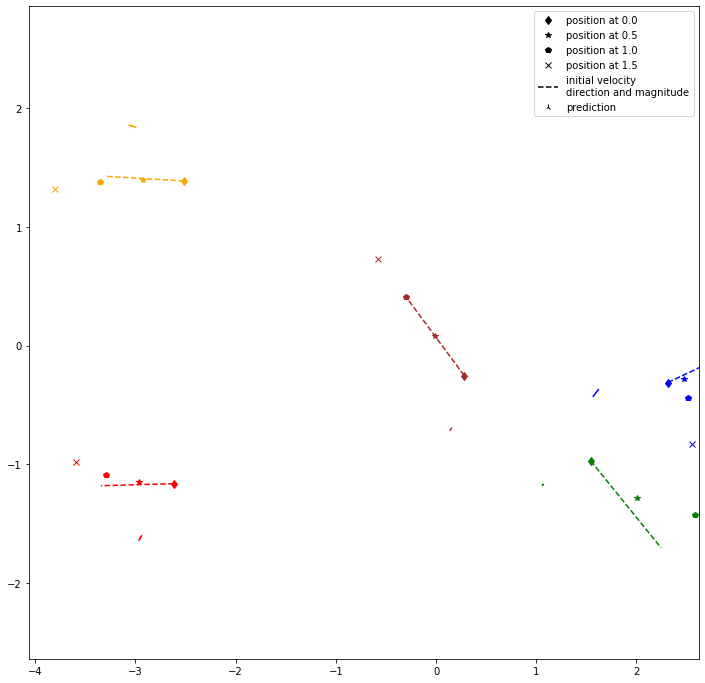

In [86]:
data = data[0].to(device="cpu")
y = y[0].to(device="cpu")

fig = plt.figure()
axes = plt.gca()
axes.set_xlim([-5., 5.])
axes.set_ylim([-5., 5.])
colors = ['red', 'blue', 'green', 'orange', 'brown']
all_x, all_y = list(), list()

for i in range(len(data)):
    plt.plot(data[i][0], data[i][1], 'd', color=colors[i])
    plt.plot(y[i][0], y[i][1], '*', color=colors[i])
    plt.plot(y[i][2], y[i][3], 'p', color=colors[i])
    plt.plot(y[i][4], y[i][5], 'x', color=colors[i])
    plt.plot([data[i][0], data[i][0] + data[i][2]], [data[i][1], data[i][1] + data[i][3]], '--', color=colors[i])
    
    x_pos, y_pos = list(), list()
    for x_x, y_y in zip(exp_x, exp_y):
        x_pos.append(x_x[i])
        y_pos.append(y_y[i])
                    
    all_x.append(x_pos)
    all_y.append(y_pos)
    plt.plot(x_pos, y_pos, color=colors[i])

fig.set_size_inches(12, 12)
plt.xlim(np.min(all_x)-1, np.max(all_x) +1)
plt.ylim(np.min(all_y)-1, np.max(all_y) +1)
plt.plot([], [], 'd', color='black', label='position at 0.0')
plt.plot([], [], '*', color='black', label='position at 0.5')
plt.plot([], [], 'p', color='black', label='position at 1.0')
plt.plot([], [], 'x', color='black', label='position at 1.5')
plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
plt.plot([], [], '2', color='black', label='prediction')
plt.legend()

plt.show()


In [26]:
import torch.nn as nn

# Evaluate the baseline model (what metrics? r2? rms?)
def rms(p_pred, p_actual):
    '''
    Return the root mean squared distance between predicted locations and actual locations.
    Where p_pred and p_actual are both (N x T x 2 x P) tensors.
    '''
    mse = nn.MSELoss()
    return mse(p_pred, p_actual).sqrt().item()

def baseline_evaluate(p, v, time):
    '''
    Evaluate the baseline "model" at given time in {0, 0.5, 1, 1.5}.
    '''
    p_pred = baseline_predict(p[:, :1, :, :], v, time)
    idx = int(time / 0.5)
    p_actual = p[:, idx:idx+1, :, :]
    # Currently just rms, but we could add more evaluations
    return {'rms': rms(p_pred, p_actual)}

print('Baseline error should be 0:', baseline_evaluate(p_train, v_train, 0))

# Print some more metrics
for klass in ['train', 'valid', 'test']:
    p_klass, v_klass = locals()[f'p_{klass}'], locals()[f'v_{klass}']
    print(f'Error over time should increase ({klass}).')
    for t in [0.5, 1, 1.5]:
        print(f't = {t}', baseline_evaluate(p_train, v_train, t))

Baseline error should be 0: {'rms': 0.0}
Error over time should increase (train).
t = 0.5 {'rms': 0.24874936044216156}
t = 1 {'rms': 0.5171805024147034}
t = 1.5 {'rms': 0.7905893325805664}
Error over time should increase (valid).
t = 0.5 {'rms': 0.24874936044216156}
t = 1 {'rms': 0.5171805024147034}
t = 1.5 {'rms': 0.7905893325805664}
Error over time should increase (test).
t = 0.5 {'rms': 0.24874936044216156}
t = 1 {'rms': 0.5171805024147034}
t = 1.5 {'rms': 0.7905893325805664}


Text(0, 0.5, 'loss value')

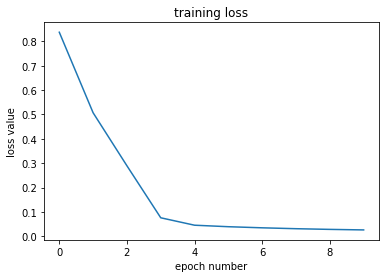

In [27]:
import matplotlib.pyplot as plt

plt.plot(train_loss_graph)
plt.title("training loss")
plt.xlabel("epoch number")
plt.ylabel("loss value")

Text(0, 0.5, 'loss value')

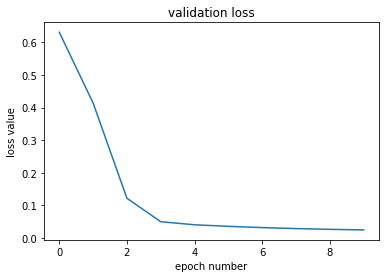

In [28]:
plt.plot(val_loss_graph)
plt.title("validation loss")
plt.xlabel("epoch number")
plt.ylabel("loss value")

# RNN doesn't work below

In [ ]:
# For sample i at time t:
# p = p' + delta_t * (v' + a * delta_t)
# trainLoader = DataLoader(myDataset(p_train, v_train, c_train), batch_size=10)
# validationLoader = DataLoader(myDataset(p_valid, v_valid, c_valid), batch_size=10)
# testLoader = DataLoader(myDataset(p_test, v_test, c_test), batch_size=10)
# x = (p,v,c), y = (p_1,p_2,p_3)

In [70]:
# RNN model

input_size = 5
hidden_size = 10
num_layers = 3

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        # self.hidden_size = hidden_size
        # self.num_layers = num_layers
        # self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # self.fc = nn.Linear(hidden_size, 1)
        self.rnn = nn.RNN(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True,
        )
        self.out = nn.Linear(hidden_size,1)
    
    def forward(self, x, h_state):
        # # Set initial hidden and cell states 
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # # Forward propagate LSTM
        # out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # # Decode the hidden state of the last time step
        # out = self.fc(out[:, -1, :])
        # return out
        r_out, h_state = self.rnn(x, h_state)
        outs = []
        for time_step in range(r_out.size(1)):
            outs.append(self.out(r_out[:,time_step,:]))
        return torch.stack(outs,dim=1), h_state


rnn_model = RNN()
rnn_model.to(device=device)
# interaction_network = InteractionNetwork()
# interaction_network.to(device=device)

RNN(
  (rnn): RNN(5, 10, num_layers=3, batch_first=True)
  (out): Linear(in_features=10, out_features=1, bias=True)
)

In [74]:
start = 0
end = 1.5
time_step = 0.01
h_state = None
num_epoch = 3
learning_rate = 0.001

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)

train_loss_graph, val_loss_graph = list(), list()

# Train the model
for epoch in range(num_epoch):
    train_loss, val_loss = list(), list()
    
    rnn_model = rnn_model.train()
    for x_train, y_train in tqdm(trainLoader, desc="Training"):
        
        #steps = np.linspace(start, end, time_step, dtype=np.float32,endpoint=False)
        y_pred, h_state = rnn_model(x_train,h_state)

        print(y_pred)
        loss = criterion(y_pred, y_train[2])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item() / num_epoch)
    
    train_loss_graph.append(sum(train_loss) / len(trainLoader))
        
    rnn_model = rnn_model.eval()
    for x_val, y_val in validationLoader:
        y_pred_val, h_state = rnn_model(x_val,h_state)
        loss = criterion(y_pred_val, y_val)
        
        val_loss.append(loss.item() / num_epoch)
    
    val_loss_graph.append(sum(val_loss) / len(validationLoader))
        
    print(f'Average loss: {train_loss_graph[-1]}')
    print(f'val loss: {val_loss_graph[-1]}')

Training:   0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([5, 6])) that is different to the input size (torch.Size([10, 5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training:   0%|          | 1/500 [00:00<02:27,  3.39it/s]

tensor([[[0.2245],
         [0.1380],
         [0.2244],
         [0.1521],
         [0.1764]],

        [[0.2028],
         [0.2078],
         [0.1442],
         [0.2459],
         [0.1237]],

        [[0.1766],
         [0.2410],
         [0.0589],
         [0.1601],
         [0.1898]],

        [[0.2259],
         [0.1859],
         [0.1699],
         [0.1980],
         [0.0413]],

        [[0.1915],
         [0.2649],
         [0.0968],
         [0.0943],
         [0.0569]],

        [[0.1669],
         [0.2089],
         [0.1863],
         [0.1574],
         [0.0657]],

        [[0.1859],
         [0.2439],
         [0.1176],
         [0.2839],
         [0.1267]],

        [[0.1887],
         [0.1651],
         [0.1909],
         [0.1738],
         [0.0090]],

        [[0.1780],
         [0.2110],
         [0.1684],
         [0.1032],
         [0.1723]],

        [[0.1596],
         [0.3078],
         [0.1245],
         [0.2128],
         [0.0881]]], device='cuda:0', grad_fn=<Stac

Training:   0%|          | 1/500 [00:00<05:12,  1.60it/s]

tensor([[[0.2003],
         [0.0468],
         [0.0720],
         [0.1034],
         [0.2423]],

        [[0.2312],
         [0.0855],
         [0.1166],
         [0.0960],
         [0.0334]],

        [[0.0152],
         [0.2180],
         [0.1581],
         [0.1402],
         [0.1178]],

        [[0.1772],
         [0.1448],
         [0.2327],
         [0.1435],
         [0.1573]],

        [[0.2719],
         [0.1764],
         [0.1352],
         [0.0734],
         [0.1444]],

        [[0.1418],
         [0.1951],
         [0.1899],
         [0.2486],
         [0.2245]],

        [[0.2151],
         [0.1248],
         [0.1524],
         [0.1868],
         [0.2214]],

        [[0.1722],
         [0.0677],
         [0.0671],
         [0.0940],
         [0.2920]],

        [[0.0817],
         [0.2116],
         [0.0759],
         [0.0730],
         [0.1216]],

        [[0.1273],
         [0.1176],
         [0.1059],
         [0.0835],
         [0.2536]]], device='cuda:0', grad_fn=<Stac

RuntimeError: ignored

# Model Training

In [30]:
#todo

# Evaluation

In [ ]:
#TODO:
# The amount of training samples should vary from 100 to 10000, and the
# prediction horizons are t = 0.5, t = 1 and t = 1.5. For each training set
# size/time horizon combination, compare to a simple linear baseline where
# xti = x0i + v0i ·t

In [ ]:
# TODO
# Come up with and execute one additional experiment that provides an interesting insight in your method
# possible idea: interpolation, i.e. given t = 1.5 and t = 0.5, where is it at t = 1?
